In [43]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.mixture import GaussianMixture
import scipy as sp
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.gmm.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
def convert_grammar_to_gmm(grammar):
    weights = grammar.params_by_node_type[Root.__name__]().detach()
    means_init = []
    vars_init = []
    for mode in Modes:
        mode_name = mode.__name__
        mean = grammar.rule_params_by_node_type[mode_name][0][0]["mean"]().detach().numpy()
        var = grammar.rule_params_by_node_type[mode_name][0][0]["variance"]().detach().numpy()
        means_init.append(mean)
        vars_init.append(var)
    means_init = np.stack(means_init)
    vars_init = np.stack(vars_init)
    return make_gmm_without_fitting(weights, means_init, vars_init)

def make_gmm_without_fitting(weights_init, means_init, vars_init):
    gmm = GaussianMixture(
        n_components=3,
        covariance_type="diag"
    )
    gmm.weights_ = deepcopy(weights_init)
    gmm.means_ = deepcopy(means_init)
    gmm.covariances_ = deepcopy(vars_init)
    gmm.precisions_ = 1./deepcopy(vars_init)
    gmm.converged_ = True
    return gmm

def convert_gmm_to_grammar(gmm):
    grammar = SpatialSceneGrammar(
        root_node_type = Root,
        root_node_tf = torch.eye(4),
        sample_params_from_prior=True
    )
    rule_probs_param = grammar.params_by_node_type[Root.__name__]
    rule_probs_param.set(torch.tensor(deepcopy(gmm.weights_)))
    for k, mode in enumerate(Modes):
        mode_name = mode.__name__
        mean_param = grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
        var_param = grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
        mean_param.set(torch.tensor(deepcopy(gmm.means_[k, :])))
        var_param.set(torch.tensor(deepcopy(gmm.covariances_[k, :])))
    return grammar


def make_random_gmm(seed):
    pyro.set_rng_seed(seed)
    # Come up with weights / means / variances manually
    weights = dist.Dirichlet(torch.ones(3)).sample().detach().numpy()
    means = dist.Uniform(torch.ones(3, 3)*-10., torch.ones(3, 3)*10.).sample().detach().numpy()
    vars = dist.Uniform(torch.ones(3, 3)*0.5, torch.ones(3, 3)*1.0).sample().detach().square().numpy()
    return make_gmm_without_fitting(weights, means, vars)
    
def make_target_grammar_and_data(seed, N):
    gmm = make_random_gmm(seed)
    X = gmm.sample(N)[0]
    return convert_gmm_to_grammar(gmm), X    
    
N_EM_ITERS_DEFAULT = 20
def do_sklearn_gmm_fit(X, weights_init, means_init, vars_init, n_em_iters=N_EM_ITERS_DEFAULT):
    gmm = GaussianMixture(
        n_components=3,
        covariance_type="diag",
        weights_init=deepcopy(weights_init),
        means_init=deepcopy(means_init),
        precisions_init=1./deepcopy(vars_init),
        max_iter=n_em_iters
    )
    gmm.fit(X)
    return convert_gmm_to_grammar(gmm)


def do_grammar_gmm_fit(X, weights_init, means_init, vars_init, n_em_iters=N_EM_ITERS_DEFAULT):
    # Make fitting grammar
    fit_grammar = SpatialSceneGrammar(
        root_node_type = Root,
        root_node_tf = torch.eye(4),
        sample_params_from_prior=True
    )
    rule_probs_param = fit_grammar.params_by_node_type[Root.__name__]
    rule_probs_param.set(torch.tensor(deepcopy(weights_init)))
    for k, mode in enumerate(Modes):
        mode_name = mode.__name__
        mean_param = fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
        var_param = fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
        mean_param.set(torch.tensor(deepcopy(means_init[k, :])))
        var_param.set(torch.tensor(deepcopy(vars_init[k, :])))
    
    observed_nodes = []
    for x in X:
        observed_nodes.append([Point(tf=drake_tf_to_torch_tf(RigidTransform(p=x)))])
    em = EMWrapper(fit_grammar, observed_nodes, max_scene_extent_in_any_dir=20)
    em.do_iterated_em_fitting(em_iterations=n_em_iters, tqdm=tqdm, N_solutions=3, num_workers=10)
    return fit_grammar, em

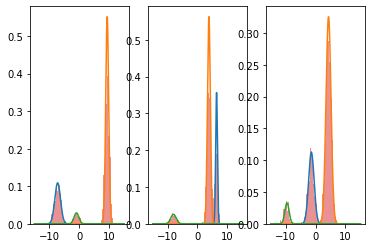

In [48]:
target_grammar, X = make_target_grammar_and_data(11, 1000)


def plot_grammar_modes(grammar, axs):
    xs = np.linspace(-15, 15, 1000)
    for k, label in enumerate("xyz"):
        rule_probs_param = grammar.params_by_node_type[Root.__name__]
        modes = []
        for mode in Modes:
            mode_name = mode.__name__
            mean_param = grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
            var_param = grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
            modes.append((mean_param(), var_param()))

        for mode_k, (prob, mode) in enumerate(zip(rule_probs_param().detach().numpy(), modes)):
            mode = torch.exp(dist.Normal(mode[0][k], mode[1][k]).log_prob(torch.tensor(xs))).detach().numpy() * prob
            axs[k].plot(xs, mode, label="Mode %d" % mode_k)

def plot_grammar_samples(grammar, axs, X):
    for k, label in enumerate("xyz"):
        axs[k].hist(X[:, k], bins=50, alpha=0.5, density=True)
        
def make_figure_for_grammar(grammar, X, axs):
    plot_grammar_modes(grammar, axs)
    plot_grammar_samples(grammar, axs, X)

fig, axs = plt.subplots(1, 3)
make_figure_for_grammar(target_grammar, X, axs)

In [49]:
def do_comparison_run(seed, N_samples=100):
    assert seed >= 0
    target_grammar, X = make_target_grammar_and_data(seed, N_samples)
    init_gmm = make_random_gmm(seed + 1)
    gmm_fit_grammar = do_sklearn_gmm_fit(X, init_gmm.weights_, init_gmm.means_, init_gmm.covariances_)
    grammar_fit_grammar, em_history = do_grammar_gmm_fit(X, init_gmm.weights_, init_gmm.means_, init_gmm.covariances_)
    return {
        "target_grammar": target_grammar,
        "X": X,
        "init_gmm": init_gmm,
        "gmm_fit_grammar": gmm_fit_grammar,
        "grammar_fit_grammar": grammar_fit_grammar,
        "grammar_fit_em_history": em_history
    }

def do_comparison_runs(N_runs, save_file):
    if os.path.exists(save_file):
        os.remove(save_file)
    for k in tqdm(range(N_runs)):
        res_dict = do_comparison_run(k)
        with open(save_file, 'ab') as fp:
            pickle.dump(res_dict,fp)

FILENAME = "test_runs.pickle"
RERUN = False
if RERUN or not os.path.exists(FILENAME):
    print("Rerunning experiment...")
    do_comparison_runs(20, FILENAME)
else:
    print("Experiment not being rerun.")

Rerunning experiment...


  0%|          | 0/20 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:01<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Plot results

In [50]:
all_result_dicts = []
with open(FILENAME, "rb") as fp:
    try:
        while True:
            all_result_dicts.append(pickle.load(fp))
    except EOFError:
        pass
print("Loaded %d experiment runs" % len(all_result_dicts))

Loaded 20 experiment runs


[0.5013457137053883, 3.5867474359148437, 1.6021724001050215, 1.9045244294172425, 1.5904139000319217, 3.197946151903015, 0.6513482900396307, 4.8423783804653855, 1.5067259625597453, 1.1816692373650692, 0.961227819983449, 5.84837299350975, 3.0567779382424094, 0.9431715876955988, 1.0886073529827431, 4.6393263558695494, 0.8280838751965323, 1.668258936075611, 2.318894550719746, 3.0385741038821577]


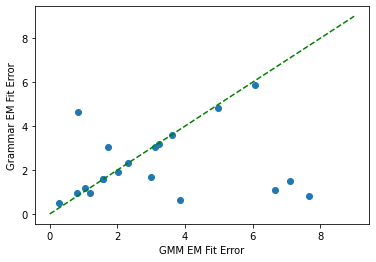

In [57]:
# Histogram of errors
# Extract a large number of samples from the GT and fit models,
# and compare their distance to the GT distribution as a sum of
# the 1D EMD (Wasserstein) distances.
def get_model_error(gt_samples, fit_samples):
    return sum([sp.stats.wasserstein_distance(gt_samples[:, k], fit_samples[:, k]) for k in range(3)])
def make_scatter_of_errors(all_result_dicts, N_samples=10000):
    gmm_errs = []
    grammar_errs = []
    for result_dict in all_result_dicts:
        gt_samples = convert_grammar_to_gmm(result_dict["target_grammar"]).sample(N_samples)[0]
        gmm_fit_samples = convert_grammar_to_gmm(result_dict["gmm_fit_grammar"]).sample(N_samples)[0]
        grammar_fit_samples = convert_grammar_to_gmm(result_dict["grammar_fit_grammar"]).sample(N_samples)[0]
        gmm_errs.append(get_model_error(gt_samples, gmm_fit_samples))
        grammar_errs.append(get_model_error(gt_samples, grammar_fit_samples))
    plt.scatter(gmm_errs, grammar_errs)
    plt.xlabel("GMM EM Fit Error")
    plt.ylabel("Grammar EM Fit Error")
    print(grammar_errs)
    plt.plot(np.arange(0., 10.), np.arange(0., 10.), linestyle="--", c="green")
make_scatter_of_errors(all_result_dicts)

Final params:  tensor([0.0100, 0.0200, 0.9700])


GaussianMode_0 :
mean tensor([[-1.0582,  6.6446, -9.9061],
        [-6.9700,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185],
        [-6.9701,  7.1565, -2.9185]])
0:xyz:mean final: tensor([-6.9701,  7.1565, -2.9185])
variance tensor([[6.1864e-01, 2.7717e-01, 3.2418e-01],
        [6.3714e-06, 8.7695e-06, 2.6522e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06],

GaussianMode_2 :
mean tensor([[-1.9523,  2.5384, -0.5819],
        [ 5.4927,  4.4177,  3.1727],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355],
        [ 5.6212,  4.3895,  3.2355]])
0:xyz:mean final: tensor([5.6212, 4.3895, 3.2355])
variance tensor([[ 0.9124,  0.3176,  0.6974],
        [10.0000,  1.6676,  6.6193],
        [10.0000,  1.6066,  6.3011],
        [10.0000,  1.6066,  6

<Figure size 432x288 with 0 Axes>

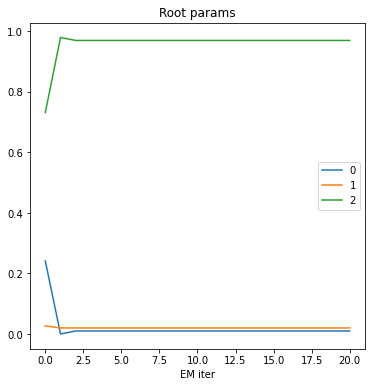

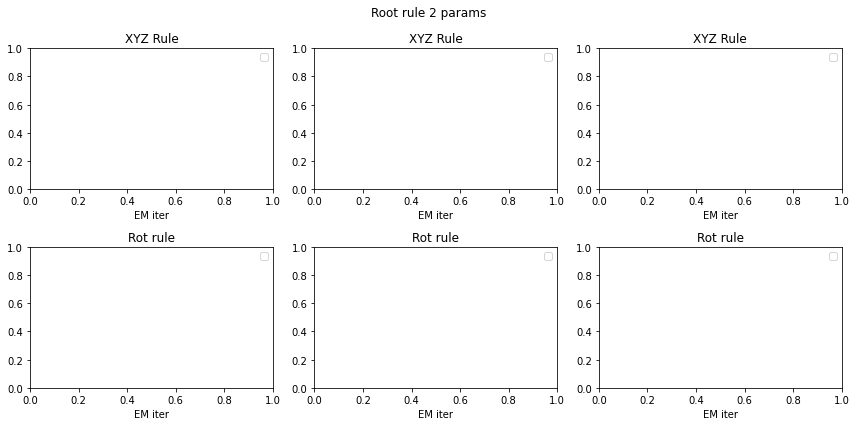

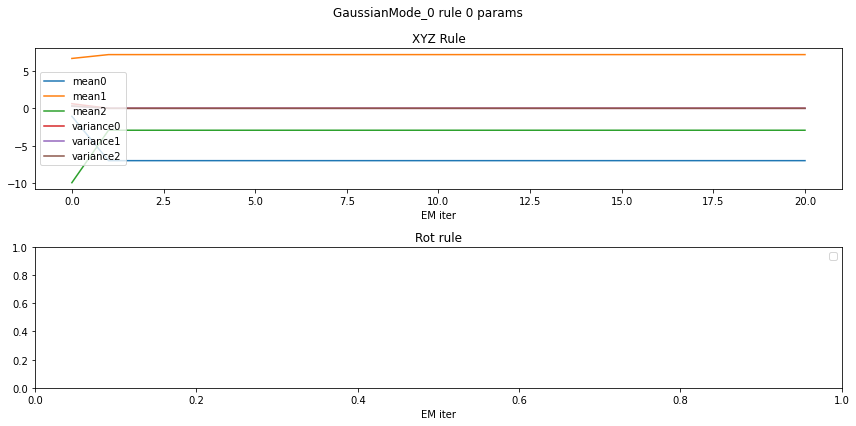

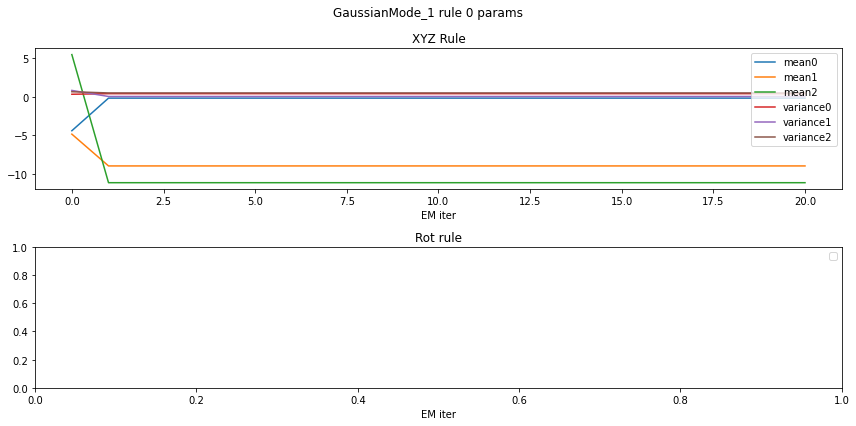

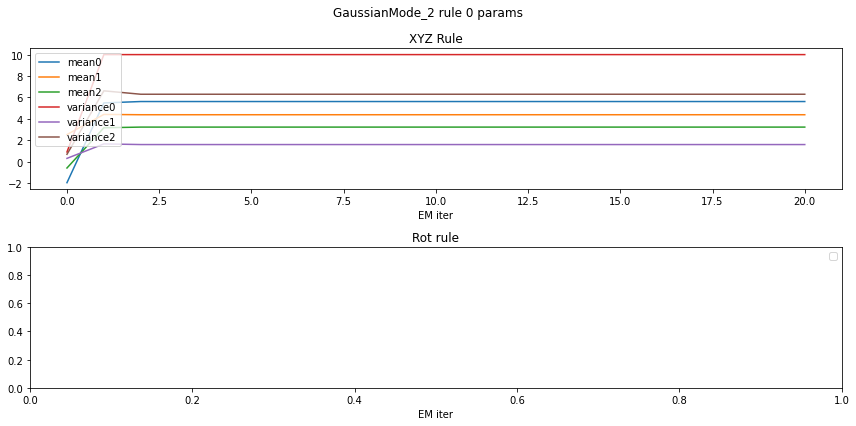

In [52]:
%matplotlib inline
#Make animation of fitting process
from matplotlib.animation import FuncAnimation
from IPython import display

plotting_grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4)
)
em = all_result_dicts[11]["grammar_fit_em_history"]
X = all_result_dicts[11]["X"]


plt.figure()
em.plot_grammar_parameter_history(Root)
for mode in Modes:
    print(mode.__name__, ":")
    em.plot_grammar_parameter_history(mode)

    
fig, axs = plt.subplots(1, 3)
#fig.set_dpi(100)

fig.set_size_inches(18, 6)
plt.suptitle("MIP-parse + EM fit")
def update(frame):
    plotting_grammar.load_state_dict(em.grammar_iters[frame])
    for ax in axs:
        ax.cla()
    make_figure_for_grammar(plotting_grammar, X, axs)
    plt.suptitle("MIP-parse + EM fit, iter %02d" % frame)
    for ax in axs:
        ax.set_xlim([-10., 10.])
        ax.set_ylim([0., 0.7])
ani = FuncAnimation(fig, update, frames=range(len(em.grammar_iters)), blit=False, interval=500.)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

# Run GMM EM and Grammar EM in lockstep

In [58]:
seed = 15
N_samples = 50
N_steps = 20
target_grammar, X = make_target_grammar_and_data(seed, N_samples)
init_gmm = make_random_gmm(seed + 1)
gmm_fit_grammars = [
    do_sklearn_gmm_fit(X, init_gmm.weights_, init_gmm.means_, init_gmm.covariances_, k+1)
    for k in range(N_steps)
]
gmm_fit_grammars.insert(0, convert_gmm_to_grammar(init_gmm))
grammar_fit_grammar, em_history = do_grammar_gmm_fit(X, init_gmm.weights_, init_gmm.means_, init_gmm.covariances_, N_steps)

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


EM Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[array([[-3.56085905, -9.49357181, -6.19517626],
       [-1.61070661,  4.56614107,  9.35535969],
       [ 0.20108916,  1.52222015, -8.76193322]]), array([[ 9.51939746,  8.07521653, -5.81374378],
       [ 0.90119012,  6.79342696,  5.72350611],
       [-3.97625324,  9.55539997, -9.94978719]]), array([[ 9.51939746,  8.07521653, -5.81374378],
       [ 0.90119012,  6.79342696,  5.72350611],
       [-3.97625324,  9.55539997, -9.94978719]]), array([[ 9.51939746,  8.07521653, -5.81374378],
       [ 0.90119012,  6.79342696,  5.72350611],
       [-3.97625324,  9.55539997, -9.94978719]]), array([[ 9.51939746,  8.07521653, -5.81374378],
       [ 0.90119012,  6.79342696,  5.72350611],
       [-3.97625324,  9.55539997, -9.94978719]]), array([[ 9.51939746,  8.07521653, -5.81374378],
       [ 0.90119012,  6.79342696,  5.72350611],
       [-3.97625324,  9.55539997, -9.94978719]]), array([[ 9.51939746,  8.07521653, -5.81374378],
       [ 0.90119012,  6.79342696,  5.72350611],
       [-3.97625324,  9.555

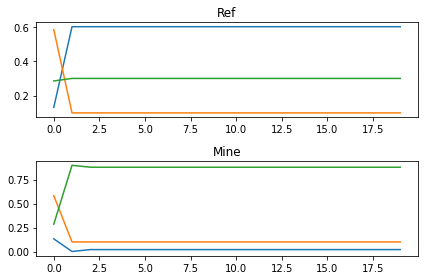

In [59]:
ref_weights_history = []
my_weights_history = []
ref_means_history = []
my_means_history = []
plotting_grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4)
)
for k in range(N_steps):
    ref_gmm = convert_grammar_to_gmm(gmm_fit_grammars[k])
    ref_weights_history.append(ref_gmm.weights_)
    ref_means_history.append(ref_gmm.means_)
    plotting_grammar.load_state_dict(em_history.grammar_iters[k])
    my_gmm = convert_grammar_to_gmm(plotting_grammar)
    my_weights_history.append(my_gmm.weights_)
    my_means_history.append(my_gmm.means_)
    
plt.figure()
plt.subplot(2, 1, 1)
plt.title("Ref")
ref_weight_history = np.stack(ref_weights_history)
plt.plot(ref_weight_history, label="Reference")
plt.subplot(2, 1, 2)
plt.title("Mine")
my_weight_history = np.stack(my_weights_history)
plt.plot(my_weight_history, label="Mine")
plt.tight_layout()

print(ref_means_history)
print(my_means_history)
    
fig, axs = plt.subplots(2, 3)
#fig.set_dpi(100)

fig.set_size_inches(18, 6)
plt.suptitle("MIP-parse + EM fit")
def update(frame):
    plotting_grammar.load_state_dict(em_history.grammar_iters[frame])
    for ax in axs.flatten():
        ax.cla()
    make_figure_for_grammar(plotting_grammar, X, axs[0, :])
    make_figure_for_grammar(gmm_fit_grammars[frame], X, axs[1, :])
    plt.suptitle("MIP-parse + EM fit, iter %02d" % frame)
    for ax in axs.flatten():
        ax.set_xlim([-10., 10.])
        ax.set_ylim([0., 0.7])
ani = FuncAnimation(fig, update, frames=range(len(em_history.grammar_iters)), blit=False, interval=500.)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()              


In [55]:
inference_results = infer_mle_tree_with_mip(
        grammar_fit_grammar, [Point(tf=drake_tf_to_torch_tf(RigidTransform(p=[9., 3., 5.])))], verbose=True,
        max_scene_extent_in_any_dir=20,
        N_solutions=3
)
mip_optimized_trees = get_optimized_trees_from_mip_results(inference_results)
for k in range(3):
    print(mip_optimized_trees[k].score(), mip_optimized_trees[k].nodes)

Starting setup.
Activation vars allocated.
Feasible
Feasible
Feasible
(b(0) + b(0) + b(0) + b(0))
Infeasible
Continuous variables and SO(3) constraints allocated for all equivalence sets.
Setup time:  0.013907670974731445
Num vars:  40
Num constraints:  141
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Tue Oct 26 01:14:10 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 126 rows, 40 columns and 395 nonzeros
Model fingerprint: 0x586948d1
Model has 9 quadratic objective terms
Variable types: 30 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e-01, 5e+01]
  Objective range  [1e-01, 2e+01]
  QObjective range [1e-01, 1e+06]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 53 rows and 19 columns
Presolve time: 0.00s
Presolved: 73 rows, 21 columns, 255 nonzeros
Variable types: 18 continuous, 3 integer (3 binary)

Root relaxation: objective 3.693426e+01, 21 i